In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import xgboost as xgb
from lime.lime_tabular import LimeTabularExplainer
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import PartialDependenceDisplay
import shap

### doing exercises

#### 1. Train at least two advanced models on the energy dataset from TSA_Example notebook. You may choose to use only the last 5 years of the dataset to reduce data size


In [10]:
import kagglehub
import os
# Download latest version
path = kagglehub.dataset_download("robikscube/hourly-energy-consumption")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\Bruger\.cache\kagglehub\datasets\robikscube\hourly-energy-consumption\versions\3


In [11]:
dataset_path = "C:/Users/Bruger/.cache/kagglehub/datasets/robikscube/hourly-energy-consumption/versions/3"

files = os.listdir(dataset_path)
print(files)

['AEP_hourly.csv', 'COMED_hourly.csv', 'DAYTON_hourly.csv', 'DEOK_hourly.csv', 'DOM_hourly.csv', 'DUQ_hourly.csv', 'EKPC_hourly.csv', 'est_hourly.paruqet', 'FE_hourly.csv', 'NI_hourly.csv', 'PJME_hourly.csv', 'PJMW_hourly.csv', 'pjm_hourly_est.csv', 'PJM_Load_hourly.csv']


In [12]:
file_path = "C:/Users/Bruger/.cache/kagglehub/datasets/robikscube/hourly-energy-consumption/versions/3/PJME_hourly.csv"

In [13]:
df = pd.read_csv(file_path)
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)
df = df.sort_index()
df

,PJME_MW
Datetime,
2002-01-01 01:00:00,30393.0
2002-01-01 02:00:00,29265.0
2002-01-01 03:00:00,28357.0
2002-01-01 04:00:00,27899.0
2002-01-01 05:00:00,28057.0
...,...
2018-08-02 20:00:00,44057.0
2018-08-02 21:00:00,43256.0
2018-08-02 22:00:00,41552.0


In [14]:
df = df[(df.index.max() - pd.Timedelta(days=365*5)):df.index.max()]
df

,PJME_MW
Datetime,
2013-08-04 00:00:00,28588.0
2013-08-04 01:00:00,26466.0
2013-08-04 02:00:00,24892.0
2013-08-04 03:00:00,23879.0
2013-08-04 04:00:00,23165.0
...,...
2018-08-02 20:00:00,44057.0
2018-08-02 21:00:00,43256.0
2018-08-02 22:00:00,41552.0


In [15]:
def create_features(df):
    """
    Create time series features and lag features based on time series index.
    """
    df = df.copy()

    # Basic time-based features
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week

    # Lag features
    df['lag_1d'] = df['PJME_MW'].shift(1)   # 1 day lag
    df['lag_1w'] = df['PJME_MW'].shift(7)   # 1 week lag
    df['lag_1m'] = df['PJME_MW'].shift(30)  # 1 month lag (approx. 30 days)
    df['lag_1y'] = df['PJME_MW'].shift(365) # 1 year lag

    # Rolling statistics features
    df['rolling_mean_3d'] = df['PJME_MW'].rolling(window=3).mean()  # Last 3 days rolling mean
    df['rolling_mean_30d'] = df['PJME_MW'].rolling(window=30).mean()  # Last month rolling mean
    df['rolling_mean_same_month_last_year'] = df['PJME_MW'].shift(365).rolling(window=30).mean()  # Same month previous year rolling mean
    df['rolling_mean_same_week_last_year'] = df['PJME_MW'].shift(365).rolling(window=7).mean()  # Same week previous year rolling mean

    return df

df = create_features(df)

In [16]:
df = df.dropna()

<Figure size 640x480 with 0 Axes>

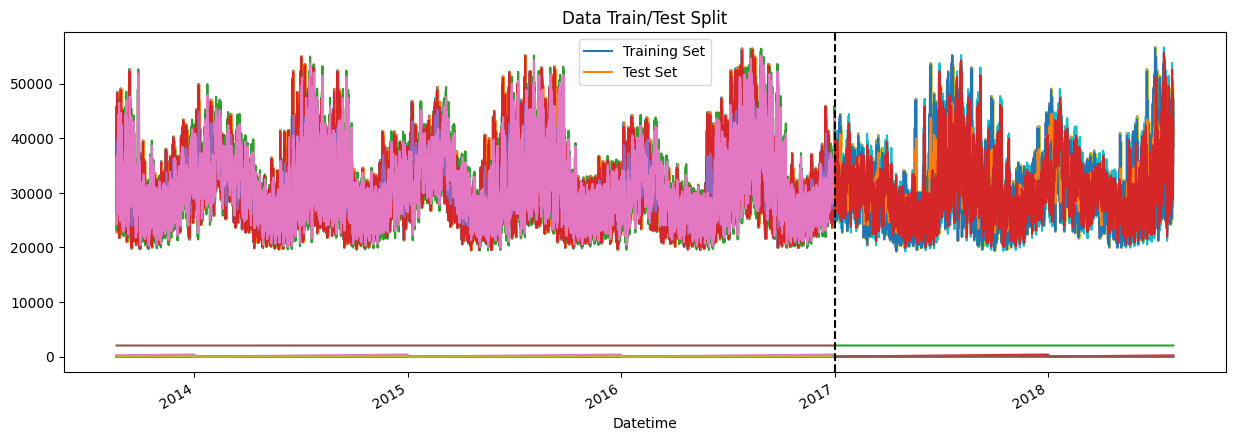

In [17]:
train = df.loc[df.index < '01-01-2017']
test = df.loc[(df.index >= '01-01-2017')]
plt.clf()
fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2017', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [18]:
TARGET = 'PJME_MW'

FEATURES = [
    'hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear',
    'lag_1d', 'lag_1w', 'lag_1m', 'lag_1y',
    'rolling_mean_3d', 'rolling_mean_30d', 'rolling_mean_same_month_last_year', 'rolling_mean_same_week_last_year'
]

In [19]:
# XGBoost Data
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [20]:
X_train

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag_1d,lag_1w,lag_1m,lag_1y,rolling_mean_3d,rolling_mean_30d,rolling_mean_same_month_last_year,rolling_mean_same_week_last_year
Datetime,,,,,,,,,,,,,,,,
2013-08-20 10:00:00,10,1,3,8,2013,232,20,34,32671.0,24604.0,22663.0,23166.0,32613.333333,31150.800000,28208.633333,25233.857143
2013-08-20 11:00:00,11,1,3,8,2013,232,20,34,34787.0,24178.0,23134.0,24437.0,34886.666667,31619.733333,28070.266667,24416.714286
2013-08-20 12:00:00,12,1,3,8,2013,232,20,34,37202.0,24430.0,24678.0,26197.0,37130.666667,32110.566667,28061.300000,24203.000000
2013-08-20 13:00:00,13,1,3,8,2013,232,20,34,39403.0,25890.0,26996.0,28501.0,39237.666667,32580.966667,28181.600000,24638.571429
2013-08-20 14:00:00,14,1,3,8,2013,232,20,34,41108.0,28174.0,29050.0,30472.0,41108.000000,33039.733333,28401.366667,25552.142857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-31 19:00:00,19,5,4,12,2016,366,31,52,34898.0,31084.0,32991.0,38749.0,34021.333333,32054.733333,40420.800000,41378.142857
2016-12-31 20:00:00,20,5,4,12,2016,366,31,52,34478.0,30461.0,32799.0,38790.0,34234.666667,32072.366667,40403.333333,40699.285714
2016-12-31 21:00:00,21,5,4,12,2016,366,31,52,33328.0,30043.0,32526.0,39299.0,33334.333333,32061.400000,40409.733333,40140.571429


In [23]:
# Train an XGBoost model
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

# Train a simple neural network
nn_model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)  # Regression output layer
])

nn_model.compile(optimizer='adam', loss='mse')
nn_model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=1, validation_split=0.1)

c:\Users\Bruger\anaconda3\envs\python_3_10_16\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
1660/1660 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 50019188.0000 - val_loss: 789974.1250
Epoch 2/50
1660/1660 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 889384.7500 - val_loss: 959005.2500
Epoch 3/50
1660/1660 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 886760.6250 - val_loss: 680390.8125
Epoch 4/50
1660/1660 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 791645.3125 - val_loss: 922666.6250
Epoch 5/50
1660/1660 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 826763.1875 - val_loss: 777583.5625
Epoch 6/50
1660/1660 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 759279.0000 - val_loss: 695570.9375
Epoch 7/50
1660/1660 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 711812.2500 - val_loss: 587419.1250
Epoch 8/50
1660/1660 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 684312.4375 - val_loss: 586173.2500
Epoch 9/50
1660/1660 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 654511.6875 - val_loss: 583739.5000
Epoch 10/50
1660/1660 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 619451.0625 - val_loss: 537806.9375
Epoch 11/50
1660/

In [ ]:
# SHAP explanation for neural network
explainer_nn = shap.Explainer(nn_model, X_train) # tried DeepExplainer and KernelExplaier, they failed
shap_values_nn = explainer_nn(X_test)

# SHAP summary plot (Global explanation)
shap.summary_plot(shap_values_nn, X_test)

# SHAP force plot for local explanation (first instance)
shap.initjs()
shap.force_plot(explainer_nn.expected_value, shap_values_nn[1000].values, X_test.iloc[1000,:], matplotlib=True)

PermutationExplainer explainer:  24%|██▎       | 3290/13896 [06:42<22:01,  8.03it/s]

 99%|===================| 13695/13896 [00:54<00:00]        

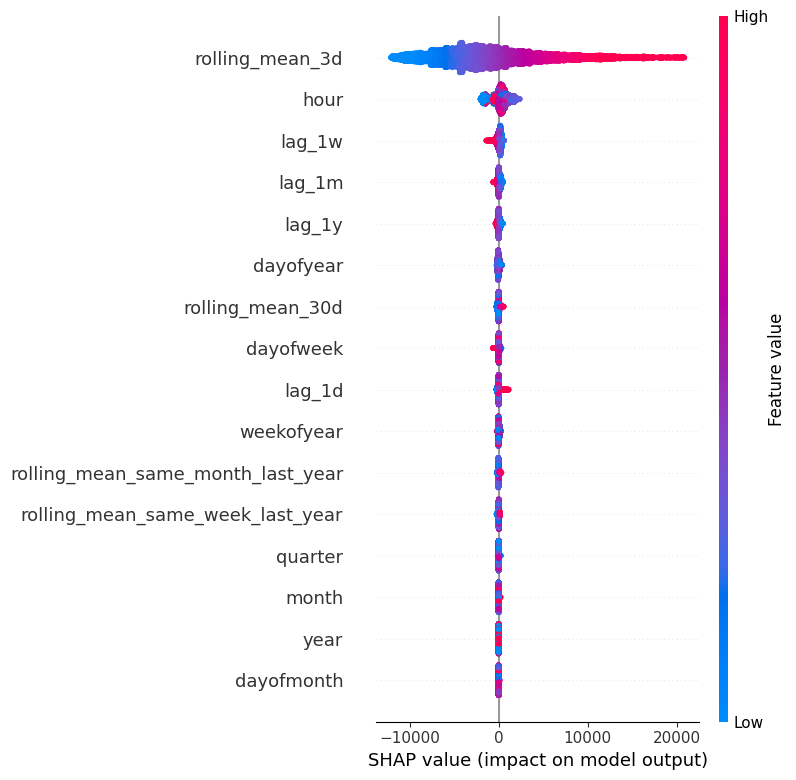

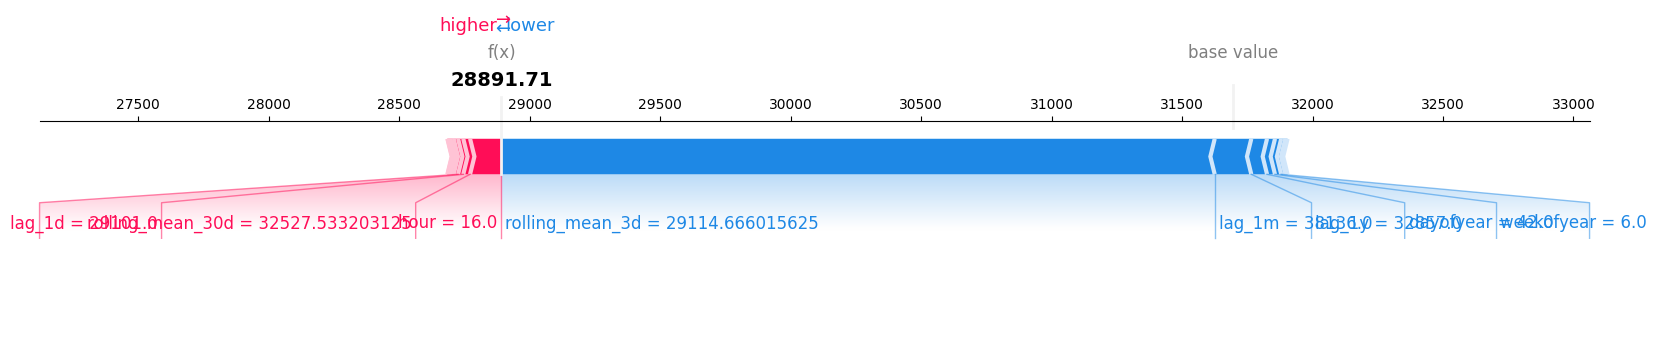

In [25]:
# SHAP explanation for XGBoost
explainer_xgb = shap.TreeExplainer(xgb_model, X_train)
shap_values_xgb = explainer_xgb(X_test)

# SHAP summary plot (Global explanation)
shap.summary_plot(shap_values_xgb, X_test)

# SHAP force plot for local explanation (first instance)
shap.initjs()
shap.force_plot(explainer_xgb.expected_value, shap_values_xgb[1000].values, X_test.iloc[1000,:], matplotlib=True)

The rolling_mean_3d has the highest impact on the model, where low value has low negative impact
and high value has high positive impact on the outcome
hour, and lag_1w has a small impact as well while the rest doesn't have much significant impact

From the instance

explain the patterns

In [ ]:
explainer = LimeTabularExplainer(X_test.values, feature_names=X_test.columns,
                                 class_names=TARGET, 
                                 mode= 'regression')

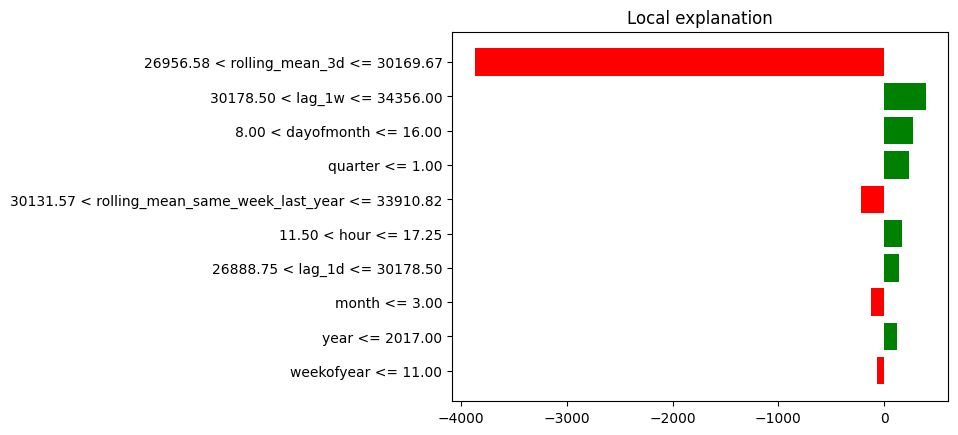

In [ ]:
explanation = explainer.explain_instance(X_test.iloc[1000].values, xgb_model.predict)

# Show the explanation
explanation.show_in_notebook(show_table=True, show_all=False)

fig = explanation.as_pyplot_figure()

# Show the plot explicitly
plt.show()

Explain lime pattern

compare answer from lime and shap, what do you see, is it the same